In [1]:
from preamble import *
from preamble import visits, systeminfo

# Define some functions we'll need

In [3]:
def warp_wavelength(wavelength, a, b, c):
    """
    Polynomial model for non-linear warping of the wavelength axis.
    
    Parameters:
    - wavelength: The original wavelength array.
    - a, b, c: Polynomial coefficients (linear and non-linear transformations).
    
    Returns:
    - Transformed wavelength array.
    """
    return a * wavelength**2 + b * wavelength + c

def align_spectrum_least_squares(reference_spectrum, wavelength, target_spectrum):
    """
    Align the target spectrum to the reference spectrum by optimizing the warping
    of the wavelength axis using least squares.
    
    Parameters:
    - reference_spectrum: The reference spectrum (1D array).
    - wavelength: The original wavelength array (1D array).
    - target_spectrum: The spectrum to be aligned (1D array).
    
    Returns:
    - aligned_spectrum: The target spectrum after aligning it to the reference spectrum.
    - optimized_wavelength: The optimized (warped) wavelength axis for the target spectrum.
    """
    
    def interpolate_spec(wavelength, a, b, c):
        """Warps the wavelength axis and interpolates the target spectrum."""
        warped_wavelength = warp_wavelength(wavelength, a, b, c)
        # Interpolate the target spectrum to the warped wavelength axis
        interpolated_spectrum = interp1d(warped_wavelength, target_spectrum, bounds_error=False, fill_value="extrapolate")(wavelength)
        return interpolated_spectrum

    # Define the initial guess for the polynomial coefficients (no warping initially)
    initial_guess = [0, 1, 0]  # a=0, b=1, c=0 implies no warping
    
    # Perform least-squares fitting to optimize the wavelength warping
    popt, _ = curve_fit(interpolate_spec, wavelength, reference_spectrum, p0=initial_guess)
    
    # Compute the optimized wavelength axis
    calibrated_wavelength = warp_wavelength(wavelength, *popt)
    
    # Interpolate the target spectrum onto the optimized wavelength axis
    aligned_spectrum = interp1d(calibrated_wavelength, target_spectrum, bounds_error=False, fill_value="extrapolate")(wavelength)
    
    return aligned_spectrum, calibrated_wavelength

def apply_least_squares_to_spectra(data, wavelength, reference_spectrum):
    """
    Apply the least-squares alignment to each time-dependent spectrum.
    
    Parameters:
    - data: 2D array of spectra (nwavelengths, ntimes)
    - wavelength: 1D array of wavelength values
    - reference_spectrum: The reference spectrum (1D array)
    
    Returns:
    - aligned_data: 2D array of aligned spectra
    - optimized_wavelengths: 2D array of the optimized (warped) wavelength axis for each time point
    """
    nwavelengths, ntimes = data.shape
    
    # Initialize arrays to store the aligned spectra and optimized wavelength axes
    aligned_data = np.zeros_like(data)
    calibrated_wavelengths = np.zeros((nwavelengths, ntimes))
    
    for i in range(ntimes):
        this_spectrum = data[:, i]
        aligned_spectrum, calibrated_wavelength = align_spectrum_least_squares(reference_spectrum, wavelength, this_spectrum)
        
        # Store the aligned spectrum and the optimized wavelength axis
        aligned_data[:, i] = aligned_spectrum
        calibrated_wavelengths[:, i] = calibrated_wavelength
    
    return aligned_data, calibrated_wavelengths

# Read Data
## Save as Rainbows
## Imshow

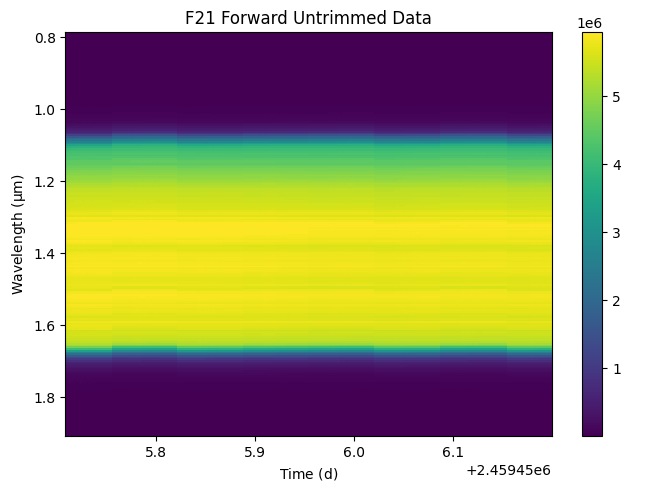

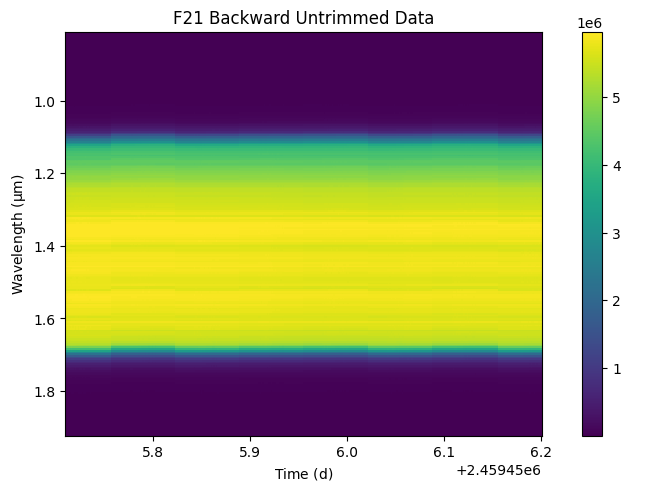

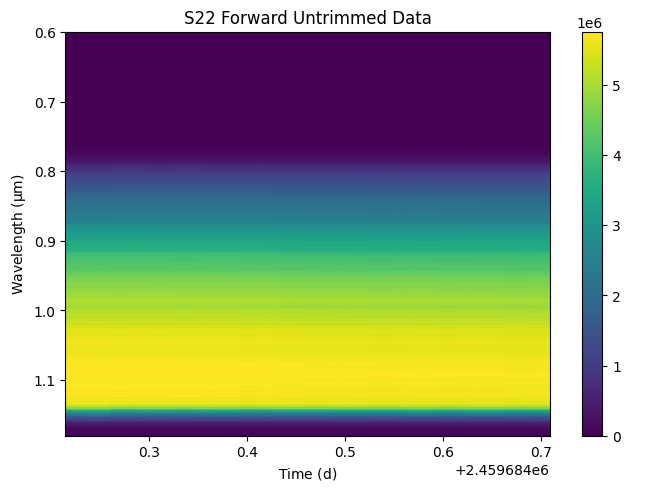

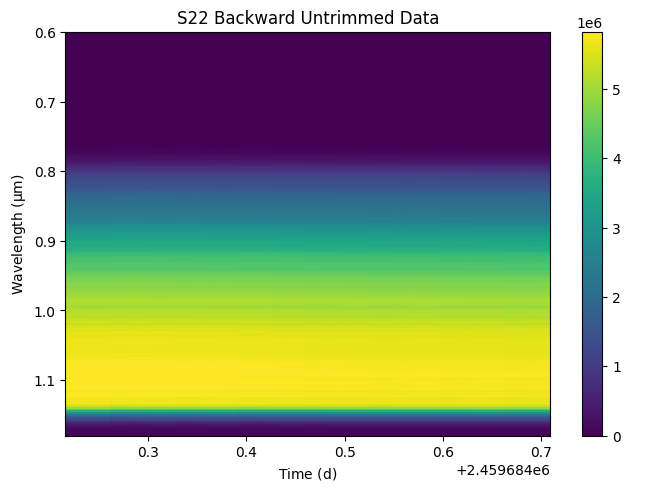

In [5]:
for visit in ['F21','S22']:
    
    for direction in ['Forward','Backward']:
        
        visit_data = visits[f'{visit}']
        spectral_data = visit_data[f'{direction}']
        bjd_times = np.array( pd.read_csv( f'../data/{visit}_bjdtimes.csv')['BJD'][:] )*u.day
        if direction == 'Backward':
            if visit == 'S22':
                bjd_times = bjd_times + 0.000671 * u.day
            if visit == 'F21':
                bjd_times = bjd_times + 0.000706 * u.day  

        untrimmed_data = Rainbow(wavelength=spectral_data['wavelength']/1e4 * u.micron,
                                 time = bjd_times,
                                 flux = spectral_data['exp_spec'],
                                 uncertainty = np.sqrt(spectral_data['exp_spec']))
        untrimmed_data.save(f"../data/{visit}_{direction}_untrimmed.rainbow.npy")

        plt.figure()
        untrimmed_data.imshow()
        plt.title(f'{visit} {direction} Untrimmed Data')
        plt.savefig(f"../figs/{visit}_{direction}_untrimmed_imshow.png")

# Perform a non-linear adjustment to wavelength and align all the spectra within a given visit

F21 Forward


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

F21 Backward


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

S22 Forward


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

S22 Backward


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

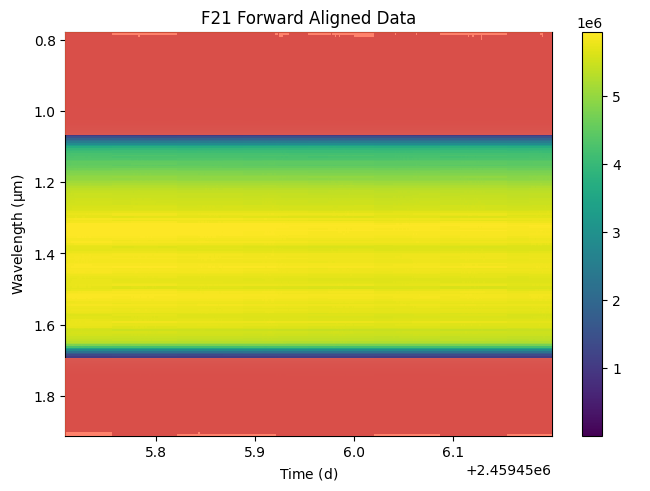

<Figure size 640x480 with 0 Axes>

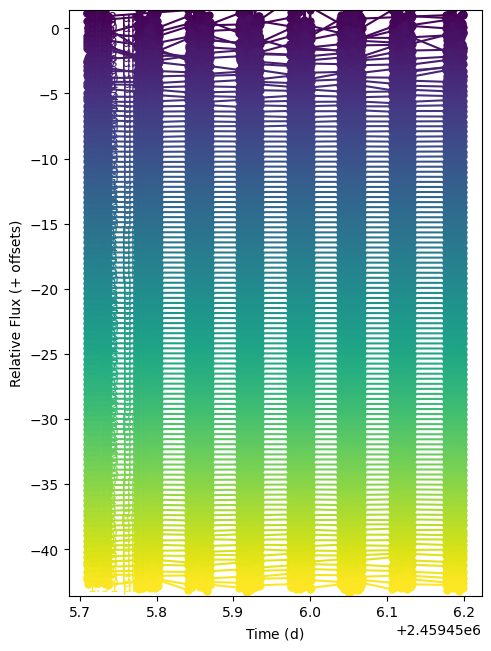

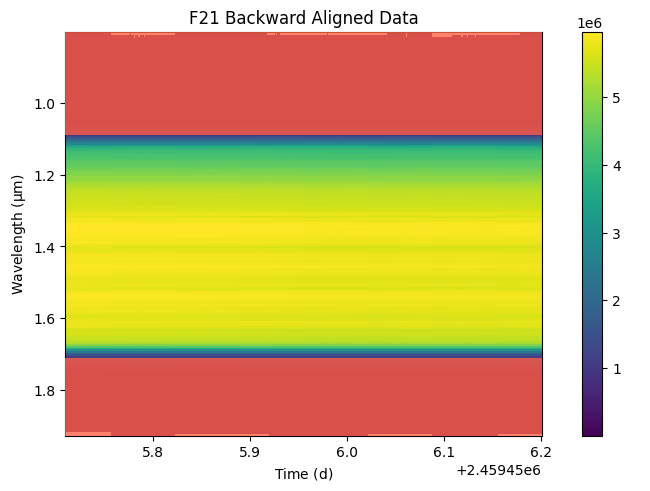

<Figure size 640x480 with 0 Axes>

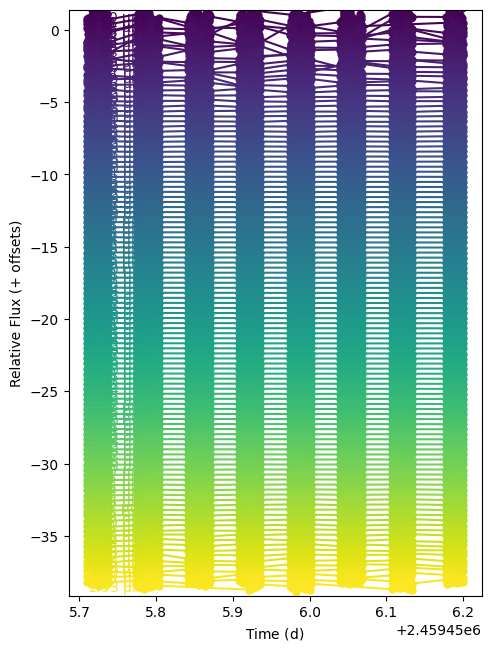

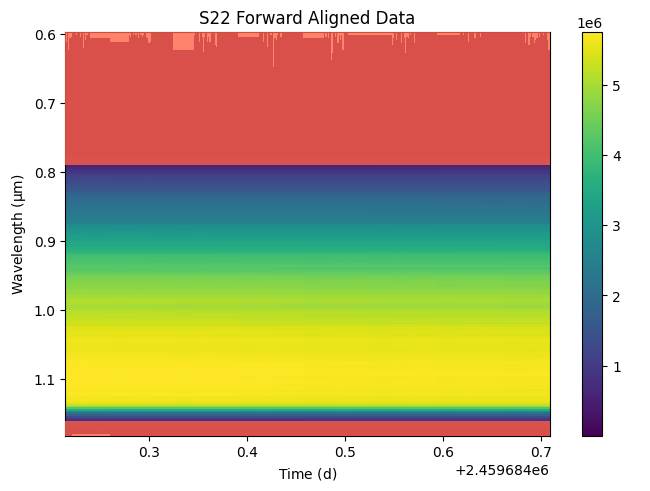

<Figure size 640x480 with 0 Axes>

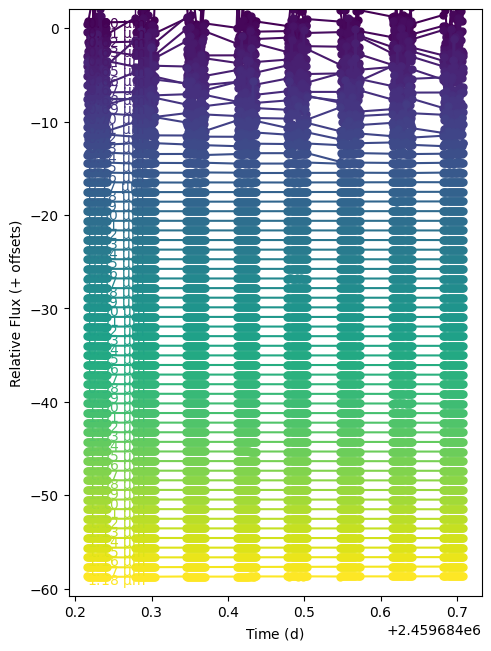

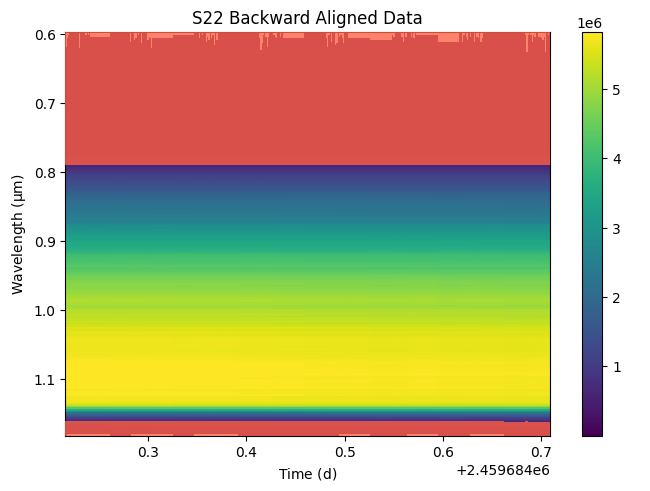

<Figure size 640x480 with 0 Axes>

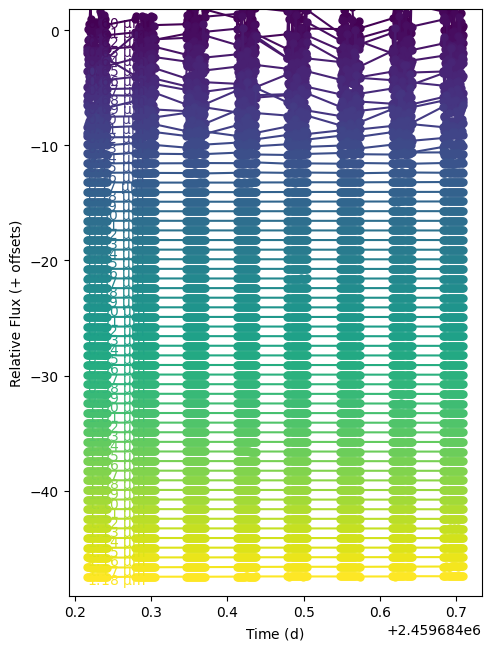

In [42]:
for visit in ['F21', 'S22']:
    
    for direction in ['Forward', 'Backward']:
        print(visit, direction)

        'Load untrimmed rainbow data'
        untrimmed_rainbow = read_rainbow(f"../data/{visit}_{direction}_untrimmed.rainbow.npy")

        'Calculate a reference spectrum which each spectrum will be aligned to'
        reference_spectrum = np.nanmedian(untrimmed_rainbow.flux,axis=1)

        'Apply least-squares alignment to all spectra'
        aligned_data, calibrated_wavelengths = apply_least_squares_to_spectra(untrimmed_rainbow.flux, untrimmed_rainbow.wavelength.value, reference_spectrum)

        untrimmed_rainbow.fluxlike["wavelength_2d"] = calibrated_wavelengths*u.micron
        aligned=untrimmed_rainbow.align_wavelengths()
        # aligned.flux = aligned_data

        aligned.fluxlike['ok']= aligned.flux >= 0.25 * np.nanmedian(aligned.flux)
        aligned.trim(just_edges=False)
        aligned.save(f"../data/{visit}_{direction}_aligned.rainbow.npy")

        
        plt.figure()
        aligned.imshow()
        plt.title(f'{visit} {direction} Aligned Data')
        plt.savefig(f"../figs/{visit}_{direction}_aligned_imshow.png")

        plt.figure()
        aligned.normalize().bin(dw=0.01*u.micron).plot()

# Align the two spectra in the first visit with each other

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

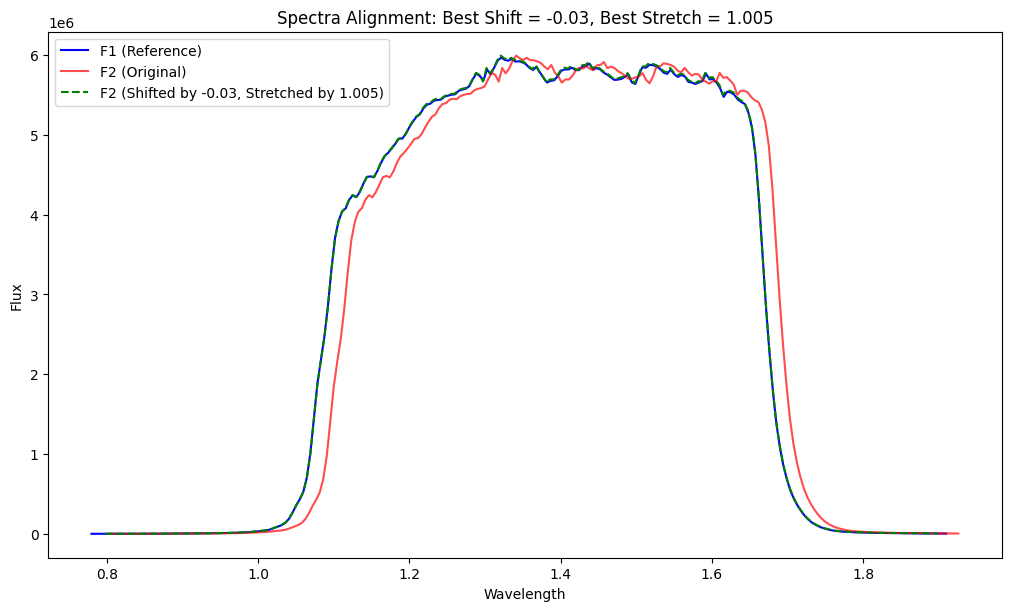

In [10]:
# Function to slide and stretch the wavelength array W2 and compute the alignment error
def slide_and_stretch_match(W1, F1, W2, F2, max_shift, step_shift, stretch_range, step_stretch):
    """Slide and stretch W2 to align F2 with F1 and return the best shift and stretch."""
    best_shift = 0
    best_stretch = 1  # No stretch as the initial condition (i.e., stretch factor = 1 means no change)
    min_error = np.inf
    best_F2_shifted = None
    best_W2_transformed = None  # Store the best transformed W2 for plotting
    
    # Try shifts within the range [-max_shift, +max_shift] and stretches in the specified range
    shifts = np.arange(-max_shift, max_shift + step_shift, step_shift)
    stretches = np.arange(stretch_range[0], stretch_range[1] + step_stretch, step_stretch)
    
    for stretch in stretches:
        for shift in shifts:
            # Apply both stretch and shift to the W2 wavelength array
            W2_transformed = W2 * stretch + shift
            
            # Compute the sum of squared differences between F1 and F2 where W2_transformed overlaps with W1
            common_range_mask = (W2_transformed >= W1.min()) & (W2_transformed <= W1.max())
            if np.sum(common_range_mask) == 0:
                continue  # Skip if no overlap
            
            F2_transformed = F2[common_range_mask]
            W2_transformed_in_common = W2_transformed[common_range_mask]
            
            # Interpolate F1 onto the shifted and stretched W2 grid for comparison
            F1_interp = np.interp(W2_transformed_in_common, W1, F1)
            
            # Calculate the error (sum of squared differences)
            error = np.sum((F1_interp - F2_transformed) ** 2)
            
            # Track the best shift and stretch (minimize the error)
            if error < min_error:
                min_error = error
                best_shift = shift
                best_stretch = stretch
                best_F2_shifted = F2_transformed
                best_W2_transformed = W2_transformed_in_common
    
    return best_shift, best_stretch, best_W2_transformed, best_F2_shifted

# Function to apply the best shift and stretch to all time-resolved spectra
def apply_shift_and_stretch_to_spectra(W2, F2_time_resolved, best_shift, best_stretch):
    """Apply the best shift and stretch to each time-resolved spectrum."""
    # Apply stretch and shift to the W2 wavelength grid
    W2_transformed = W2 * best_stretch + best_shift
    
    # Adjust the entire wavelength grid (same shift and stretch for all time-resolved spectra)
    F2_transformed_time_resolved = []
    for i in range(F2_time_resolved.shape[1]):  # Loop over each time (i.e., column in F2_time_resolved)
        F2_spectrum = F2_time_resolved[:, i]  # Get the i-th time-resolved spectrum
        F2_transformed_time_resolved.append(F2_spectrum)  # Append without changing flux, only wavelength adjusted
    
    return W2_transformed, np.array(F2_transformed_time_resolved).T  # Return time-resolved spectra (same shape)

max_shift = 0.1  # Maximum shift in wavelength units
# step_shift = 0.00467  # Step size for the shift
step_shift = 0.001  # Step size for the shift
stretch_range = [0.95, 1.05]  # Allow 5% stretch (from 0.95 to 1.05)
step_stretch = 0.0005  # Step size for stretch factor

F21F_rainbow = read_rainbow("../data/F21_Forward_aligned.rainbow.npy")
F21B_rainbow = read_rainbow("../data/F21_Backward_aligned.rainbow.npy")
S22F_rainbow = read_rainbow("../data/S22_Forward_aligned.rainbow.npy")
S22B_rainbow = read_rainbow("../data/S22_Backward_aligned.rainbow.npy")

W1 = F21F_rainbow.wavelength.value  # Wavelength array for first spectrum
W2 = F21B_rainbow.wavelength.value  # Wavelength array for second spectrum
F1 = F21F_rainbow.get_average_spectrum()  # Average spectrum for F1
F2 = F21B_rainbow.get_average_spectrum()  # Average spectrum for F2

# Perform the sliding and stretching alignment using the average spectra
best_shift, best_stretch, best_W2_transformed, best_F2_shifted = slide_and_stretch_match(W1, F1, W2, F2, max_shift, step_shift, stretch_range, step_stretch)

# Get the time-resolved spectra from the F2 data
F2_time_resolved = F21B_rainbow.flux  # Shape (nwavelengths, ntimes)

# Apply the same shift and stretch to all time-resolved spectra in F2
W2_transformed, F2_transformed_time_resolved = apply_shift_and_stretch_to_spectra(W2, F2_time_resolved, best_shift, best_stretch)

# F21B_rainbow.flux = F2_transformed_time_resolved
F21B_rainbow.wavelength = W2_transformed*u.micron
F21B_rainbow.save("../data/F21_Backward_aligned.rainbow.npy")

# Plot the average result after applying the shift and stretch to the time-resolved spectra
plt.figure(figsize=(10, 6))
plt.plot(W1, F1, label='F1 (Reference)', color='blue')
plt.plot(W2, F2, label='F2 (Original)', color='red', alpha=0.7)
plt.plot(W2_transformed, np.mean(F21B_rainbow.flux, axis=1), label=f'F2 (Shifted by {best_shift:.2f}, Stretched by {best_stretch:.3f})', color='green', linestyle='dashed')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.title(f'Spectra Alignment: Best Shift = {best_shift:.2f}, Best Stretch = {best_stretch:.3f}')
plt.show()

# Plot the white light curves and 1D spectra and determine trim regions

F21 Forward



  0%|          | 0/243 [00:00<?, ?it/s]

F21 Backward



  0%|          | 0/243 [00:00<?, ?it/s]

S22 Forward



  0%|          | 0/242 [00:00<?, ?it/s]

S22 Backward



  0%|          | 0/242 [00:00<?, ?it/s]

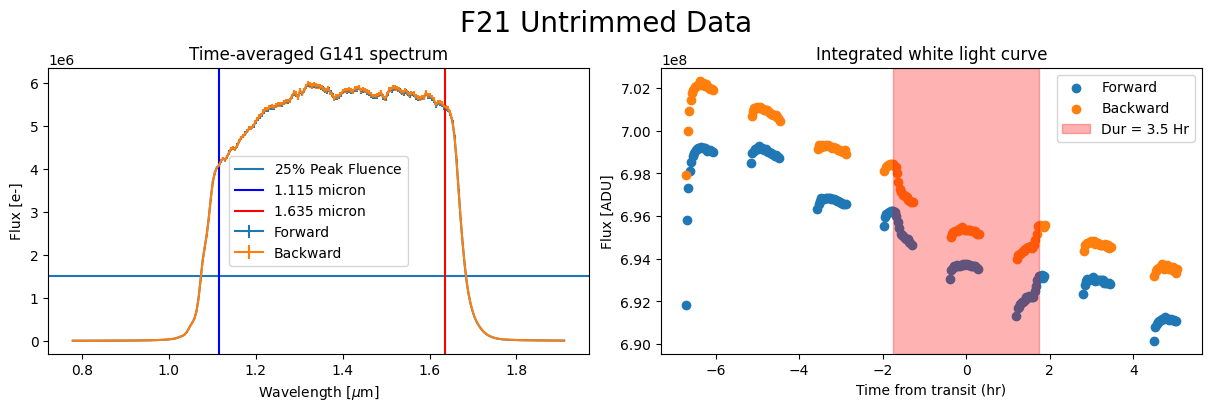

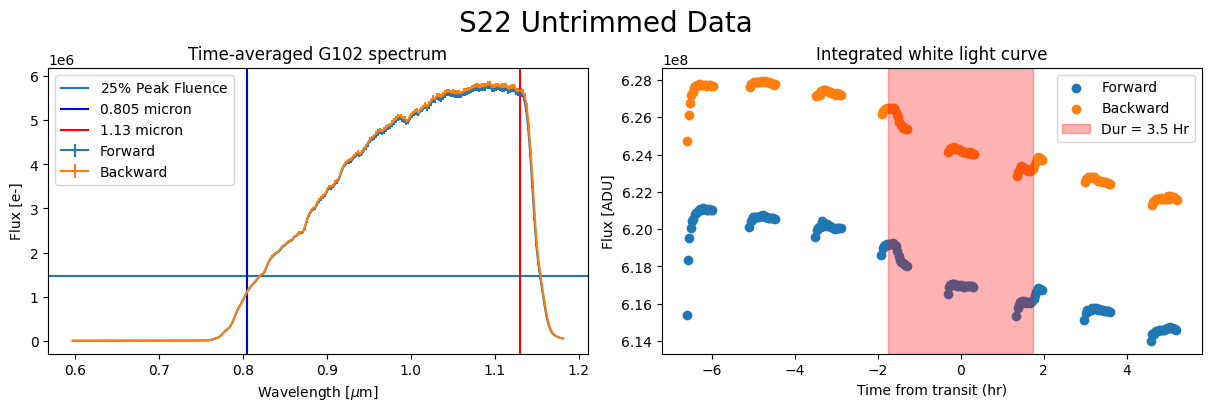

In [12]:
for visit in ['F21','S22']:
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

    for direction in ['Forward','Backward']:

        print(visit,direction)
        print('')

        'Read in the data from the previous step'
        aligned_rainbow = read_rainbow(f"../data/{visit}_{direction}_aligned.rainbow.npy")
        # aligned_rainbow.wavelength = aligned_rainbow.wavelength*stretch + shift

        visit_data = visits[f'{visit}']        
        grism = visit_data['Grism']
        t0 = visit_data['T0 (BJD_TDB)']
        if visit =='F21':
            wave_lower = 1.115*u.micron # blue-end cutoff for trimming
            wave_upper = 1.635*u.micron # red-end cutoff for trimming
        if visit =='S22':
            wave_lower = 0.805*u.micron # blue-end cutoff for trimming
            wave_upper = 1.13*u.micron # red-end cutoff for trimming
        
        'Calculate the white light curve'
        white_light_curve = np.nansum(aligned_rainbow.flux, axis=0)
        white_light_curve_err = 100e-6*white_light_curve

        'Calculate the average spectrum'
        average_spec = aligned_rainbow.get_average_spectrum()
        average_spec_err = np.abs(0.01*average_spec)
        
        'Plot'
        ax1.errorbar(aligned_rainbow.wavelength, average_spec, yerr=average_spec_err,label=f'{direction}')
        ax2.scatter((aligned_rainbow.time.value-t0.value)*24, white_light_curve, label=f'{direction}')

    ax1.axhline(0.25*np.nanmax(average_spec),label=r'25$\%$ Peak Fluence')
    ax1.axvline(wave_lower.value,label=f'{wave_lower.value} micron',color='blue')
    ax1.axvline(wave_upper.value,label=f'{wave_upper.value} micron',color='red')
    ax1.legend()
    ax1.set_title(f'Time-averaged {grism} spectrum')
    ax1.set_xlabel(r'Wavelength [$\mu$m]')
    ax1.set_ylabel('Flux [e-]')
    
    ax2.axvspan(-1.75, 1.75, alpha=0.3,color='r',label='Dur = 3.5 Hr')
    # ax2.axvspan((first_orbit_start.value-t0.value)*24, (first_orbit_end.value-t0.value)*24,label=f'First Orbit',alpha=0.3,zorder=-100,color='gray',linestyle='')
    ax2.legend()
    ax2.set_title(f'Integrated white light curve')
    ax2.set_xlabel(r'Time from transit (hr)')
    ax2.set_ylabel('Flux [ADU]')
    
    plt.suptitle(f'{visit} Untrimmed Data',size=20)
    plt.savefig(f"../figs/{visit}_untrimmed_data.png")

# Apply the trim limits determined in the last step, and plot the trimmed data

F21 Forward



  0%|          | 0/107 [00:00<?, ?it/s]

F21 Backward



  0%|          | 0/107 [00:00<?, ?it/s]

S22 Forward



  0%|          | 0/123 [00:00<?, ?it/s]

S22 Backward



  0%|          | 0/124 [00:00<?, ?it/s]

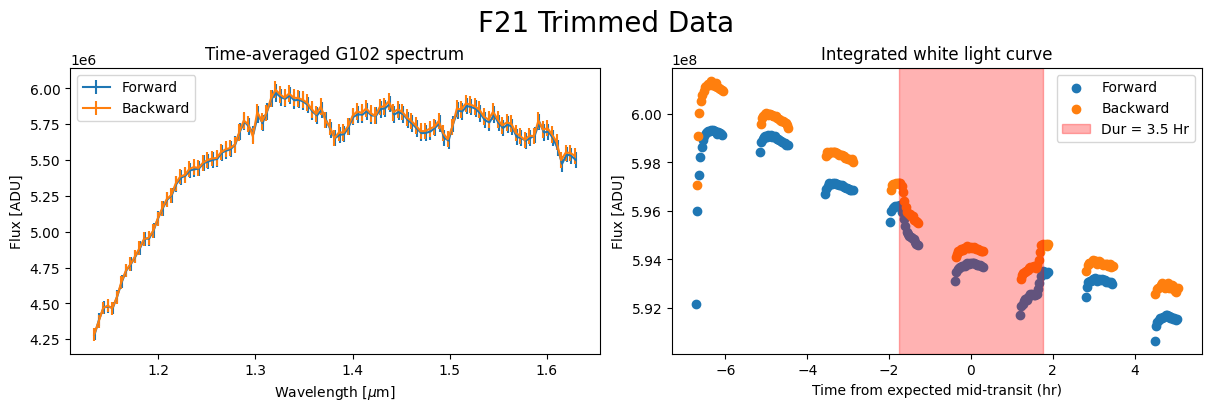

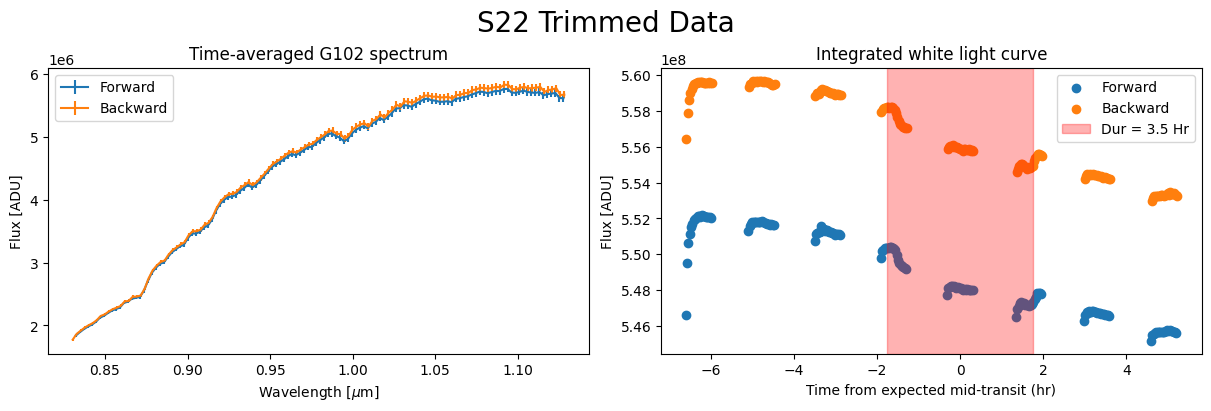

In [14]:
for visit in ['F21','S22']:
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

    for direction in ['Forward','Backward']:
        print(visit,direction)
        print('')
        
        'Load data tables'
        visit_data = visits[f'{visit}']        
        t0 = visit_data['T0 (BJD_TDB)']
        if visit =='F21':
            wave_lower = 1.13*u.micron # blue-end cutoff for trimming
            wave_upper = 1.63*u.micron # red-end cutoff for trimming
        if visit =='S22':
            wave_lower = 0.83*u.micron # blue-end cutoff for trimming
            wave_upper = 1.13*u.micron # red-end cutoff for trimming
        aligned_rainbow = read_rainbow(f"../data/{visit}_{direction}_aligned.rainbow.npy")
        wavelength = aligned_rainbow.wavelength
        'Trim the bad wavelengths from the wavelength and flux arrays'
        a = (wave_upper >= wavelength)
        b = (wavelength >= wave_lower)
        ok_wavelengths = (a == b) # trim the edges of each spectrum, where no flux is detected
        wave = wavelength[ok_wavelengths]    
        _flux = aligned_rainbow.flux[ok_wavelengths,:]
        time = aligned_rainbow.time

        'Turn the wavelength-trimmed data into a Rainbow object and save to a file to use later'
        trimmed = Rainbow(wavelength=wave, time=aligned_rainbow.time, flux=_flux, uncertainty=np.sqrt(_flux))
        trimmed.save(f"../data/{visit}_{direction}_trimmed.rainbow.npy")

        'Calculate the white light curve'
        white_light_curve = np.nansum(trimmed.flux,axis=0)
        'Calculate the average spectrum'
        average_spec = trimmed.get_average_spectrum()
        average_spec_err = 0.01*average_spec #up to debate how to calculate this
        
        ''' Plot  '''
        ax1.errorbar(trimmed.wavelength, average_spec, yerr=average_spec_err,label=f'{direction}')
        ax2.scatter((time-t0)*24, white_light_curve, label=f'{direction}')

    ax1.legend()
    ax1.set_title(f'Time-averaged {grism} spectrum')
    ax1.set_xlabel(r'Wavelength [$\mu$m]')
    ax1.set_ylabel('Flux [ADU]')
    
    ax2.axvspan(-1.75, 1.75, alpha=0.3,color='r',label='Dur = 3.5 Hr')
    ax2.legend()
    ax2.set_title(f'Integrated white light curve')
    ax2.set_xlabel(r'Time from expected mid-transit (hr)')
    ax2.set_ylabel('Flux [ADU]')
    
    plt.suptitle(f'{visit} Trimmed Data',size=20)
    plt.savefig(f"../figs/{visit}_processed_data.png")

# Create the BT SETTL Model grid

In [16]:
hires_wavelength = np.linspace(0.7, 2.0, 10000)
grid = get_interp_stellar_spectrum(hires_wavelength)

In [17]:
# Calculate a BT SETTL model
amb_flux = grid(float(4000)) # this is in erg/cm^s/s/Angstrom
cool_flux = grid(float(3100))
model_wave = hires_wavelength[:-1]
model_flux = 0.4*cool_flux + 0.6*amb_flux

In [18]:
amb_flux = get_phoenix_photons(wavelength = hires_wavelength*u.micron, temperature=4000, metallicity=0.12, logg=4.52, R=1000)
cool_flux = get_phoenix_photons(wavelength = hires_wavelength*u.micron, temperature=3100, metallicity=0.12, logg=4.52, R=1000)

model_flux = 0.4*cool_flux[1] + 0.6*amb_flux[1]
model_wave = hires_wavelength

# Align the data to a PHOENIX reference spectrum

F21 Forward



  0%|          | 0/107 [00:00<?, ?it/s]

0.006000000000000089
1.0004999999999944


  0%|          | 0/107 [00:00<?, ?it/s]

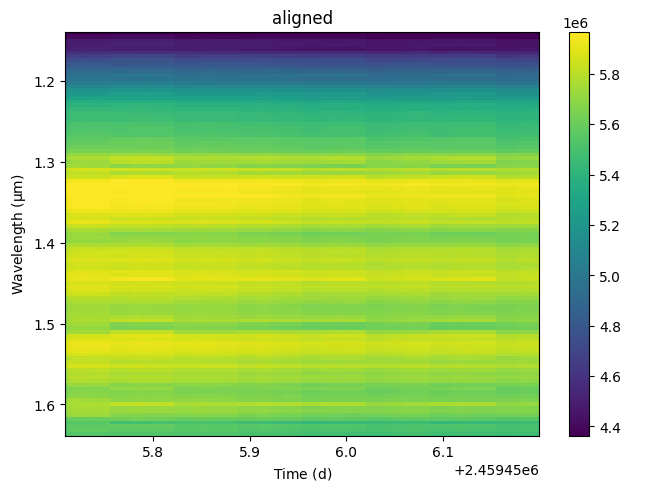

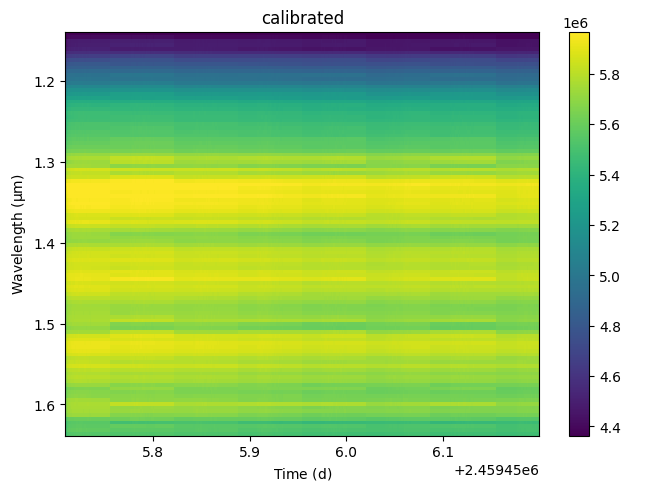

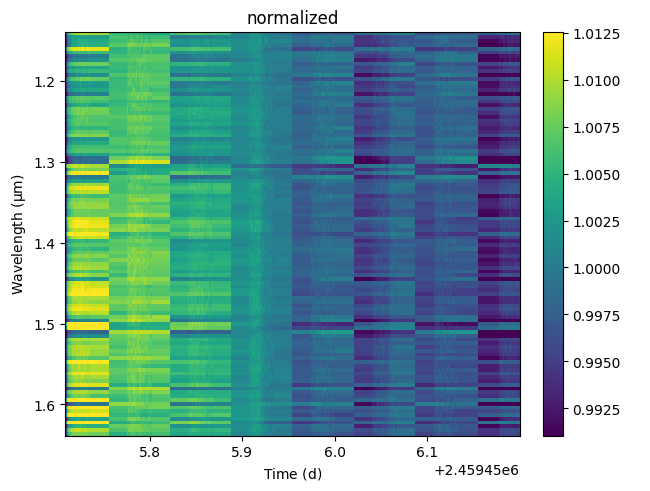

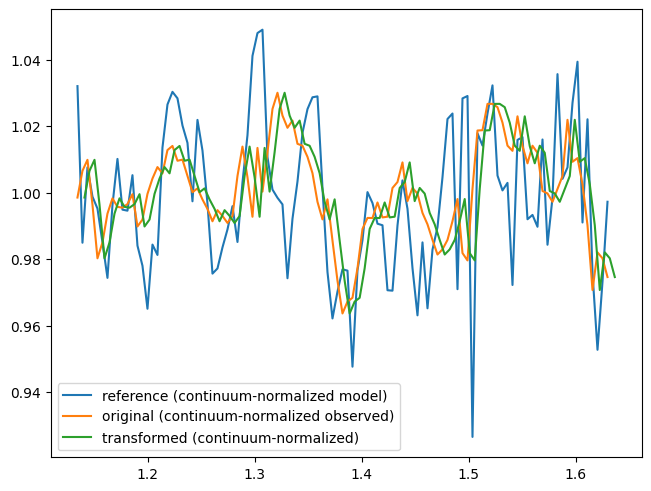

F21 Backward



  0%|          | 0/107 [00:00<?, ?it/s]

0.004000000000000087
0.9989999999999946


  0%|          | 0/107 [00:00<?, ?it/s]

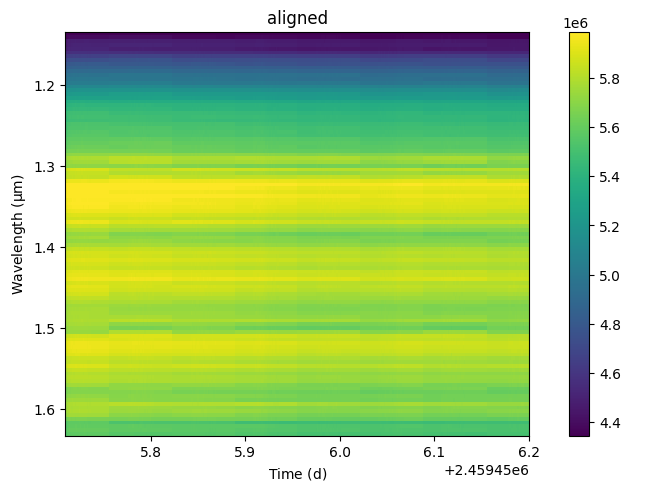

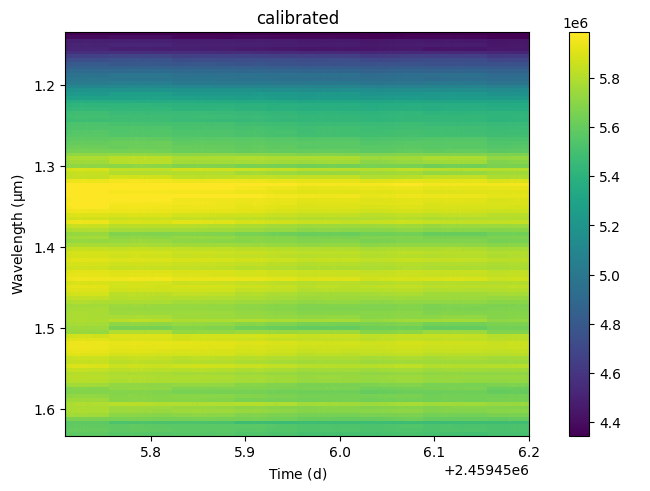

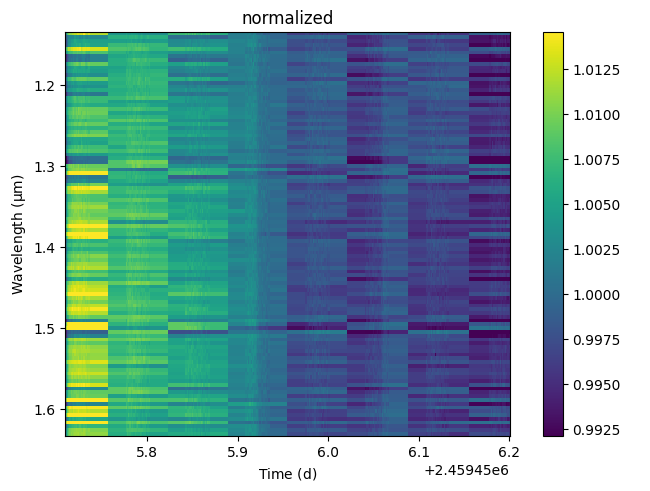

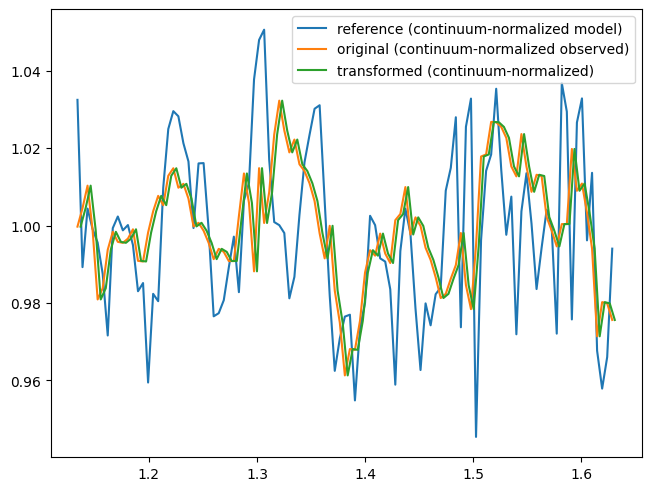

S22 Forward



  0%|          | 0/123 [00:00<?, ?it/s]

-0.0029999999999999194
0.9994999999999945


  0%|          | 0/123 [00:00<?, ?it/s]

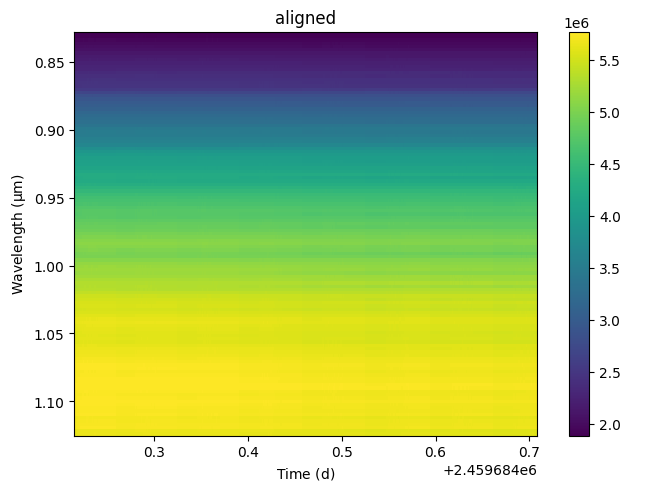

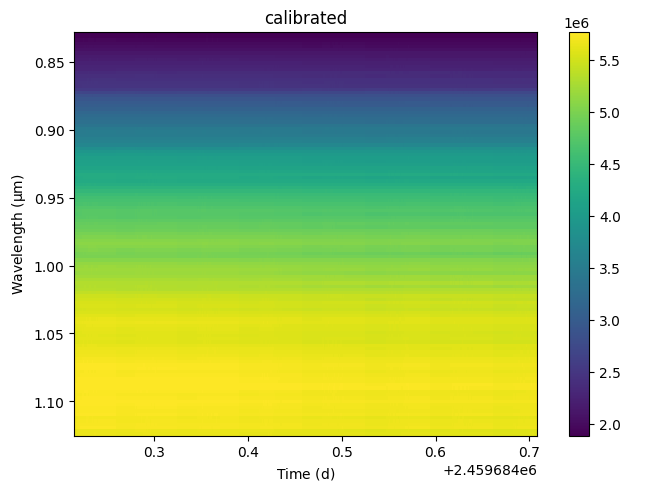

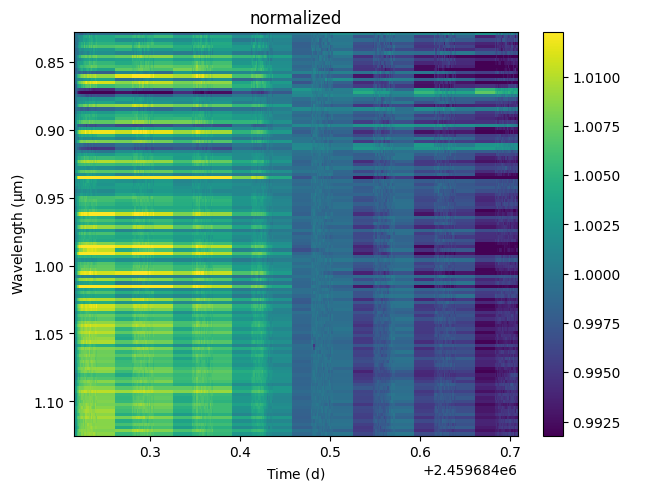

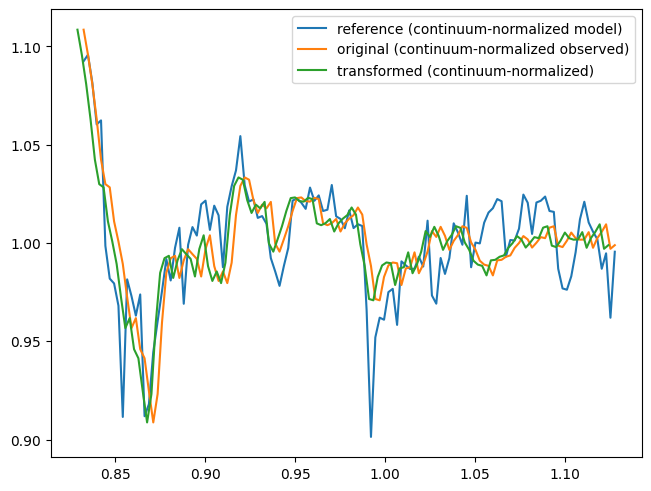

S22 Backward



  0%|          | 0/124 [00:00<?, ?it/s]

-0.00399999999999992
1.0004999999999944


  0%|          | 0/124 [00:00<?, ?it/s]

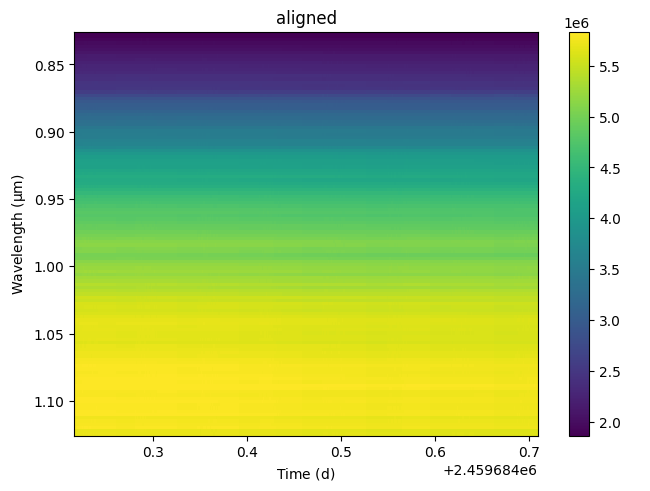

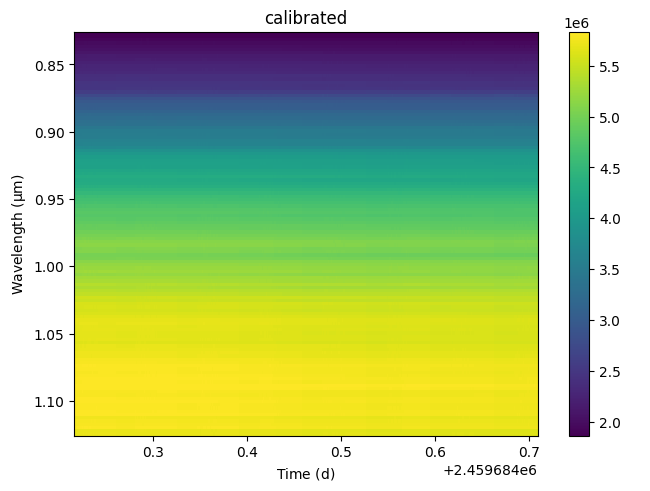

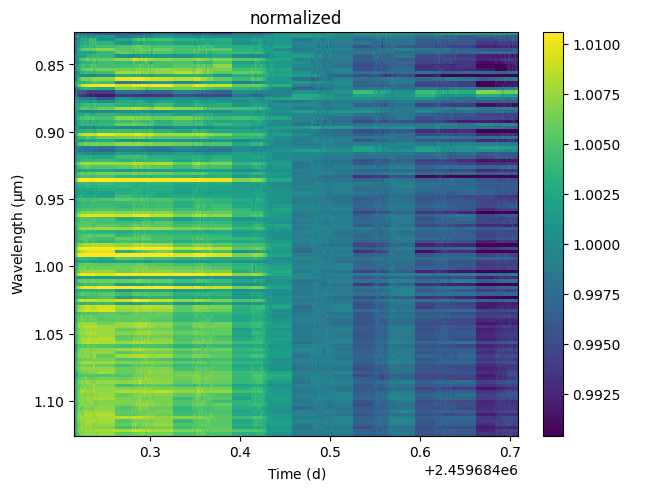

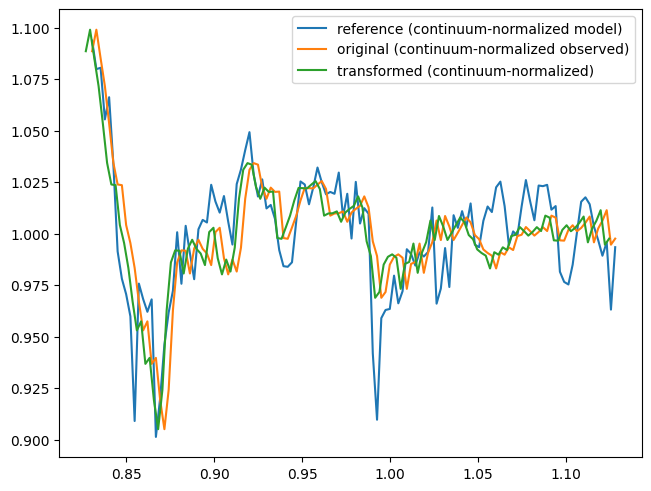

In [34]:
# Function to apply the best shift and stretch to all non-continuum-normalized spectra
def apply_shift_and_stretch_to_raw_spectra(W2, F2_time_resolved, best_shift, best_stretch):
    """Apply the best shift and stretch to each time-resolved spectrum (not continuum-normalized)."""
    # Apply stretch and shift to the W2 wavelength grid
    W2_transformed = W2 * best_stretch + best_shift
    
    # Adjust the entire wavelength grid (same shift and stretch for all time-resolved spectra)
    F2_transformed_time_resolved = []
    for i in range(F2_time_resolved.shape[1]):  # Loop over each time (i.e., column in F2_time_resolved)
        F2_spectrum = F2_time_resolved[:, i]  # Get the i-th time-resolved spectrum
        F2_transformed_time_resolved.append(F2_spectrum)  # Append without changing flux, only wavelength adjusted
    
    return W2_transformed, np.array(F2_transformed_time_resolved).T  # Return time-resolved spectra (same shape)

for visit in ['F21','S22']:
    for direction in ['Forward','Backward']:
        print(visit, direction)
        print('')
        
        # Load data tables
        visit_data = visits[f'{visit}']        
        t0 = visit_data['T0 (BJD_TDB)']

        # Read in the data from the previous step
        aligned_rainbow = read_rainbow(f"../data/{visit}_{direction}_trimmed.rainbow.npy")
        sigma = visits[f'{visit}']['filter_sigma']
        w = aligned_rainbow.wavelength

        # Calculate an average spectrum
        average_spec = aligned_rainbow.get_average_spectrum()

        # Continuum normalize the average spectrum
        contin_normed_data = continuum_correction(w, average_spec)
        
        # Convolve and interpolate the model spectrum
        convolved = convolve_spectrum(model_wave, model_flux, sigma=sigma, method='astropy', kernel_type='astropy')
        filter_response = visits[f'{visit}']['filter_response']
        resampled_filter_response = bintogrid(filter_response.wave[0].value, filter_response.throughput[0], newx=w.value)
        resampled_model = bintogrid(model_wave, convolved, newx=w.value)
        model = resampled_model['y'] * resampled_filter_response['y']
        contin_normed_model = continuum_correction(w, model)

        # W1, F1 = wavelength and flux for reference spectrum (continuum-normalized model)
        # W2, F2 = wavelength and flux for data spectrum (continuum-normalized observed)
        
        W1 = w.value
        F1 = contin_normed_model
        W2 = w.value
        F2 = contin_normed_data
        
        # Perform the sliding and stretching alignment using the average spectra
        best_shift, best_stretch, best_W2_transformed, best_F2_shifted = slide_and_stretch_match(W1, F1, W2, F2, max_shift, step_shift, stretch_range, step_stretch)
        print(best_shift)
        print(best_stretch)

        # Apply the shift and stretch to the original, non-continuum-normalized spectra
        W2_transformed, F2_transformed = apply_shift_and_stretch_to_raw_spectra(w.value, aligned_rainbow.flux, best_shift, best_stretch)
        
        # Update the wavelength and flux of the non-continuum-normalized spectra
        calibrated_rainbow = aligned_rainbow
        calibrated_rainbow.wavelength = W2_transformed*u.micron
        # calibrated_rainbow.flux = F2_transformed
        # calibrated_rainbow.uncertainty = np.sqrt(F2_transformed)
            
        # Save the calibrated rainbow object
        calibrated_rainbow.save(f"../data/{visit}_{direction}_calibrated.rainbow.npy")
        plt.figure()
        aligned_rainbow.imshow()
        plt.title('aligned')

        plt.figure()
        calibrated_rainbow.imshow()
        plt.title('calibrated')

        plt.figure()
        aligned_rainbow.normalize().imshow()
        plt.title('normalized')

        # Plot the comparison of original and transformed spectra
        plt.figure()
        plt.plot(W1, F1, label='reference (continuum-normalized model)')
        plt.plot(W2, F2, label='original (continuum-normalized observed)')
        plt.plot(calibrated_rainbow.wavelength, continuum_correction(calibrated_rainbow.wavelength, calibrated_rainbow.get_average_spectrum() ), label='transformed (continuum-normalized)')
        plt.legend()
        plt.show()